In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("weatherAUS.csv")
print(df.shape)
df.head()

(142193, 24)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [3]:
df_copy = df[df["RainTomorrow"].notna()].copy()
df_copy["Target"] = (df_copy["RainTomorrow"] == "Yes").astype(int)

numeric_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
                'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

results = []
for col in numeric_cols:
    valid_data = df_copy[[col,"Target"]].dropna()
    if len(valid_data) > (len(df["RainTomorrow"]) * 0.3):
        corr,p_value = pointbiserialr(valid_data[col],valid_data["Target"])  
        results.append({  
            "Kolon":col,
            "Corr": round(abs(corr),3), 
            "Yön": "+" if corr > 0 else "-", 
            "Eksik_%": round(df[col].isnull().sum() / len(df) * 100, 1),
            "Önem": "Yüksek" if abs(corr) > 0.15 else "Orta" if abs(corr) > 0.08 else "Düşük"
        })

results_df = pd.DataFrame(results).sort_values("Corr",ascending=False)
print(results_df.to_string(index=False))

        Kolon  Corr Yön  Eksik_%   Önem
     Sunshine 0.451   -     47.7 Yüksek
  Humidity3pm 0.446   +      2.5 Yüksek
     Cloud3pm 0.382   +     40.2 Yüksek
     Cloud9am 0.317   +     37.7 Yüksek
  Humidity9am 0.257   +      1.2 Yüksek
  Pressure9am 0.246   -      9.9 Yüksek
     Rainfall 0.239   +      1.0 Yüksek
WindGustSpeed 0.234   +      6.5 Yüksek
  Pressure3pm 0.226   -      9.8 Yüksek
      Temp3pm 0.192   -      1.9 Yüksek
      MaxTemp 0.159   -      0.2 Yüksek
  Evaporation 0.119   -     42.8   Orta
 WindSpeed9am 0.091   +      0.9   Orta
 WindSpeed3pm 0.088   +      1.8   Orta
      MinTemp 0.084   +      0.4   Orta
      Temp9am 0.026   -      0.6  Düşük


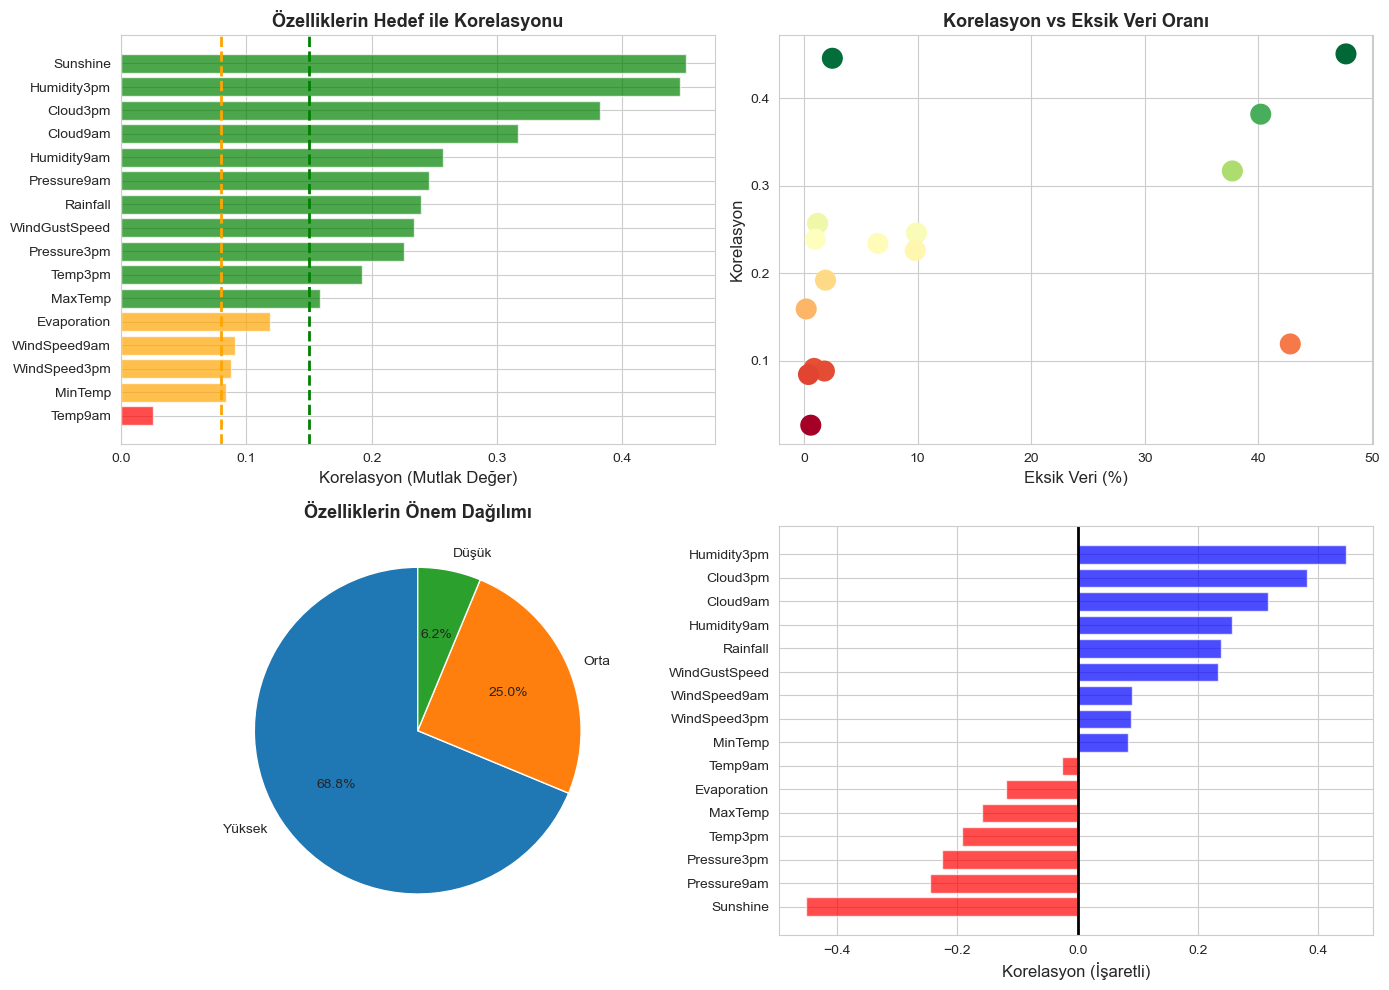

In [4]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
colors = ['green' if x == 'Yüksek' else 'orange' if x == 'Orta' else 'red' for x in results_df['Önem']]
plt.barh(results_df['Kolon'], results_df['Corr'], color=colors, alpha=0.7)
plt.xlabel('Korelasyon (Mutlak Değer)', fontsize=12)
plt.title('Özelliklerin Hedef ile Korelasyonu', fontsize=13, fontweight='bold')
plt.axvline(x=0.15, color='green', linestyle='--', linewidth=2)
plt.axvline(x=0.08, color='orange', linestyle='--', linewidth=2)
plt.gca().invert_yaxis()

plt.subplot(2, 2, 2)
scatter = plt.scatter(results_df['Eksik_%'], results_df['Corr'], s=200, c=results_df['Corr'], cmap='RdYlGn')
plt.xlabel('Eksik Veri (%)', fontsize=12)
plt.ylabel('Korelasyon', fontsize=12)
plt.title('Korelasyon vs Eksik Veri Oranı', fontsize=13, fontweight='bold')

plt.subplot(2, 2, 3)
onem_counts = results_df['Önem'].value_counts()
plt.pie(onem_counts, labels=onem_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Özelliklerin Önem Dağılımı', fontsize=13, fontweight='bold')

plt.subplot(2, 2, 4)
yon_data = results_df.copy()
yon_data['Corr_Signed'] = yon_data.apply(lambda x: x['Corr'] if x['Yön'] == '+' else -x['Corr'], axis=1)
yon_data = yon_data.sort_values('Corr_Signed')
colors_yon = ['red' if x == '-' else 'blue' for x in yon_data['Yön']]
plt.barh(yon_data['Kolon'], yon_data['Corr_Signed'], color=colors_yon, alpha=0.7)
plt.xlabel('Korelasyon (İşaretli)', fontsize=12)
plt.axvline(x=0, color='black', linewidth=2)

plt.tight_layout()
plt.show()

In [5]:
drop_list = ["WindSpeed9am","WindSpeed3pm","Evaporation","WindDir3pm","WindDir9am","WindGustDir"]
df.drop(drop_list, axis=1, inplace=True)
print(f"Kalan kolonlar: {df.shape[1]}")

Kalan kolonlar: 18


In [6]:
df["Date"] = pd.to_datetime(df["Date"])
df["Day"] = df["Date"].dt.day
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,...,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Day,Month,Year
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,44.0,71.0,22.0,1007.7,...,8.0,NaN,16.9,21.8,No,0.0,No,1,12,2008
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,44.0,44.0,25.0,1010.6,...,NaN,NaN,17.2,24.3,No,0.0,No,2,12,2008
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,46.0,38.0,30.0,1007.6,...,NaN,2.0,21.0,23.2,No,0.0,No,3,12,2008
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,24.0,45.0,16.0,1017.6,...,NaN,NaN,18.1,26.5,No,1.0,No,4,12,2008
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,41.0,82.0,33.0,1010.8,...,7.0,8.0,17.8,29.7,No,0.2,No,5,12,2008


In [7]:
numeric_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed',
                'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RISK_MM']

for col in numeric_cols:
    df[col] = df.groupby('Month')[col].transform(lambda x: x.fillna(x.mean()))

df = df.dropna()
print(f"Eksik veri sonrası satır sayısı: {len(df)}")
print(df.isnull().sum())

Eksik veri sonrası satır sayısı: 140787
Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Sunshine         0
WindGustSpeed    0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RISK_MM          0
RainTomorrow     0
Day              0
Month            0
Year             0
dtype: int64


In [8]:
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

In [9]:
df = pd.get_dummies(df, columns=["RainToday","RainTomorrow"], drop_first=True)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,...,RISK_MM,Day,Month,Year,Month_sin,Month_cos,Day_sin,Day_cos,RainToday_Yes,RainTomorrow_Yes
0,2008-12-01,Albury,13.4,22.9,0.6,8.975372,44.0,71.0,22.0,1007.7,...,0.0,1,12,2008,-2.449294e-16,1.0,0.201299,0.979530,False,False
1,2008-12-02,Albury,7.4,25.1,0.0,8.975372,44.0,44.0,25.0,1010.6,...,0.0,2,12,2008,-2.449294e-16,1.0,0.394356,0.918958,False,False
2,2008-12-03,Albury,12.9,25.7,0.0,8.975372,46.0,38.0,30.0,1007.6,...,0.0,3,12,2008,-2.449294e-16,1.0,0.571268,0.820763,False,False
3,2008-12-04,Albury,9.2,28.0,0.0,8.975372,24.0,45.0,16.0,1017.6,...,1.0,4,12,2008,-2.449294e-16,1.0,0.724793,0.688967,False,False
4,2008-12-05,Albury,17.5,32.3,1.0,8.975372,41.0,82.0,33.0,1010.8,...,0.2,5,12,2008,-2.449294e-16,1.0,0.848644,0.528964,False,False


In [10]:
location_column = df['Location'].copy()

X = df.drop(['Date', 'Day', 'Month', 'Year', 'Location', 'RainTomorrow_Yes', 'RISK_MM'], axis=1)
y = df['RainTomorrow_Yes']

X_train, X_test, y_train, y_test, loc_train, loc_test = train_test_split(
    X, y, location_column, test_size=0.3, random_state=15, stratify=y
)

print(f"Train boyutu: {len(X_train)}")
print(f"Test boyutu: {len(X_test)}")

Train boyutu: 98550
Test boyutu: 42237


In [11]:
temp_train = pd.DataFrame({
    'Location': loc_train.values,
    'RainTomorrow': y_train.values
})

location_rain_rate = temp_train.groupby('Location')['RainTomorrow'].mean()

X_train['Location_RainRate'] = loc_train.map(location_rain_rate).values
X_test['Location_RainRate'] = loc_test.map(location_rain_rate).values
X_test['Location_RainRate'].fillna(location_rain_rate.mean(), inplace=True)

print("Location encoding tamamlandı")

Location encoding tamamlandı


In [12]:
model = LogisticRegression()
penalty = ["l2"]
c_values = [10, 1, 0.1]
solver = ["lbfgs","newton-cholesky"]
class_weight = ['balanced', {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:5}]

params = dict(penalty=penalty, C=c_values, solver=solver, class_weight=class_weight)

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", cv=5, verbose=3, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'C': 1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'newton-cholesky'}
Best score: 0.82726534753932


In [13]:
model = LogisticRegression()
randomcv = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, n_iter=10, scoring="accuracy")
randomcv.fit(X_train, y_train)

print("Random best params:", randomcv.best_params_)
print("Random best score:", randomcv.best_score_)

Random best params: {'solver': 'newton-cholesky', 'penalty': 'l2', 'class_weight': {0: 1, 1: 2}, 'C': 1}
Random best score: 0.82726534753932


In [14]:
y_pred = randomcv.predict(X_test)

score = accuracy_score(y_test, y_pred)
print("Test Accuracy:", score)
print("\n" + classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.831877264010228

              precision    recall  f1-score   support

       False       0.90      0.88      0.89     32877
        True       0.61      0.66      0.64      9360

    accuracy                           0.83     42237
   macro avg       0.76      0.77      0.76     42237
weighted avg       0.84      0.83      0.83     42237


Confusion Matrix:
[[28952  3925]
 [ 3176  6184]]


In [21]:
from sklearn.metrics import precision_score, recall_score

print("\n" + "="*70)
print(" "*20 + "DETAYLI MODEL DEĞERLENDİRME")
print("="*70)


cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(cm)
print(f"\nTrue Negatives (Doğru - Yağmur Yok): {tn:,}")
print(f"False Positives (Yanlış Alarm): {fp:,}")
print(f"False Negatives (Kaçan Yağmur): {fn:,} ")
print(f"True Positives (Doğru - Yağmur Var): {tp:,}")


total_rain_days = tp + fn
total_no_rain_days = tn + fp

print(f"\n{'İSTATİSTİKLER':^70}")
print("-"*70)
print(f"Yağmurlu günlerin {(tp/total_rain_days)*100:.1f}%'ini doğru tahmin ettik")
print(f"Yağmurlu günlerin {(fn/total_rain_days)*100:.1f}%'ini kaçırdık")
print(f"Yağmursuz günlerin {(fp/total_no_rain_days)*100:.1f}%'inde yanlış alarm verdik")


print(f"\n{'SINIFLANDIRMA RAPORU':^70}")
print("-"*70)
print(classification_report(y_test, y_pred, 
                          target_names=['Yağmur Yok', 'Yağmur Var'],
                          digits=4))


print(f"\n{'GENEL METRİKLER':^70}")
print("-"*70)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision (Yağmur Var): {precision_score(y_test, y_pred):.4f}")
print(f"Recall (Yağmur Var): {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score (Yağmur Var): {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, best_proba):.4f}")


                    DETAYLI MODEL DEĞERLENDİRME

Confusion Matrix:
[[28952  3925]
 [ 3176  6184]]

True Negatives (Doğru - Yağmur Yok): 28,952
False Positives (Yanlış Alarm): 3,925
False Negatives (Kaçan Yağmur): 3,176 
True Positives (Doğru - Yağmur Var): 6,184

                            İSTATİSTİKLER                             
----------------------------------------------------------------------
Yağmurlu günlerin 66.1%'ini doğru tahmin ettik
Yağmurlu günlerin 33.9%'ini kaçırdık
Yağmursuz günlerin 11.9%'inde yanlış alarm verdik

                         SINIFLANDIRMA RAPORU                         
----------------------------------------------------------------------
              precision    recall  f1-score   support

  Yağmur Yok     0.9011    0.8806    0.8908     32877
  Yağmur Var     0.6117    0.6607    0.6353      9360

    accuracy                         0.8319     42237
   macro avg     0.7564    0.7706    0.7630     42237
weighted avg     0.8370    0.8319    0.8341 